In [1]:
import pandas as pd
import os
import numpy as np
import glidertools as gt

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from cartopy import config
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import cmocean
import netCDF4
from netCDF4 import Dataset
import datetime

import glidertools as gt
import glob
import xarray as xa

import pygmt
import statistics

In [87]:
#bathymetry


def load_bathymetry(zip_file_url):
    """Read zip file from Natural Earth containing bathymetry shapefiles"""
    # Download and extract shapefiles
    import io
    import zipfile

    import requests
    r = requests.get(zip_file_url)
    z = zipfile.ZipFile(io.BytesIO(r.content))
    z.extractall("ne_10m_bathymetry_all/")

    # Read shapefiles, sorted by depth
    shp_dict = {}
    files = glob('ne_10m_bathymetry_all/*.shp')
    assert len(files) > 0
    files.sort()
    depths = []
    for f in files:
        depth = '-' + f.split('_')[-1].split('.')[0]  # depth from file name
        depths.append(depth)
        bbox = (-175, -160, 50, 60)  # (x0, y0, x1, y1)
        nei = shpreader.Reader(f, bbox=bbox)
        shp_dict[depth] = nei
    depths = np.array(depths)[::-1]  # sort from surface to bottom
    return depths, shp_dict


if __name__ == "__main__":
    # Load data (14.8 MB file)
    depths_str, shp_dict = load_bathymetry(
        'https://naturalearth.s3.amazonaws.com/' +
        '10m_physical/ne_10m_bathymetry_all.zip')

    # Construct a discrete colormap with colors corresponding to each depth
    depths = depths_str.astype(int)
    N = len(depths)
    nudge = 0.01  # shift bin edge slightly to include data
    boundaries = [min(depths)] + sorted(depths+nudge)  # low to high
    norm = matplotlib.colors.BoundaryNorm(boundaries, N)
    blues_cm = matplotlib.colormaps['Blues_r'].resampled(N)
    colors_depths = blues_cm(norm(depths))

TypeError: 'module' object is not callable

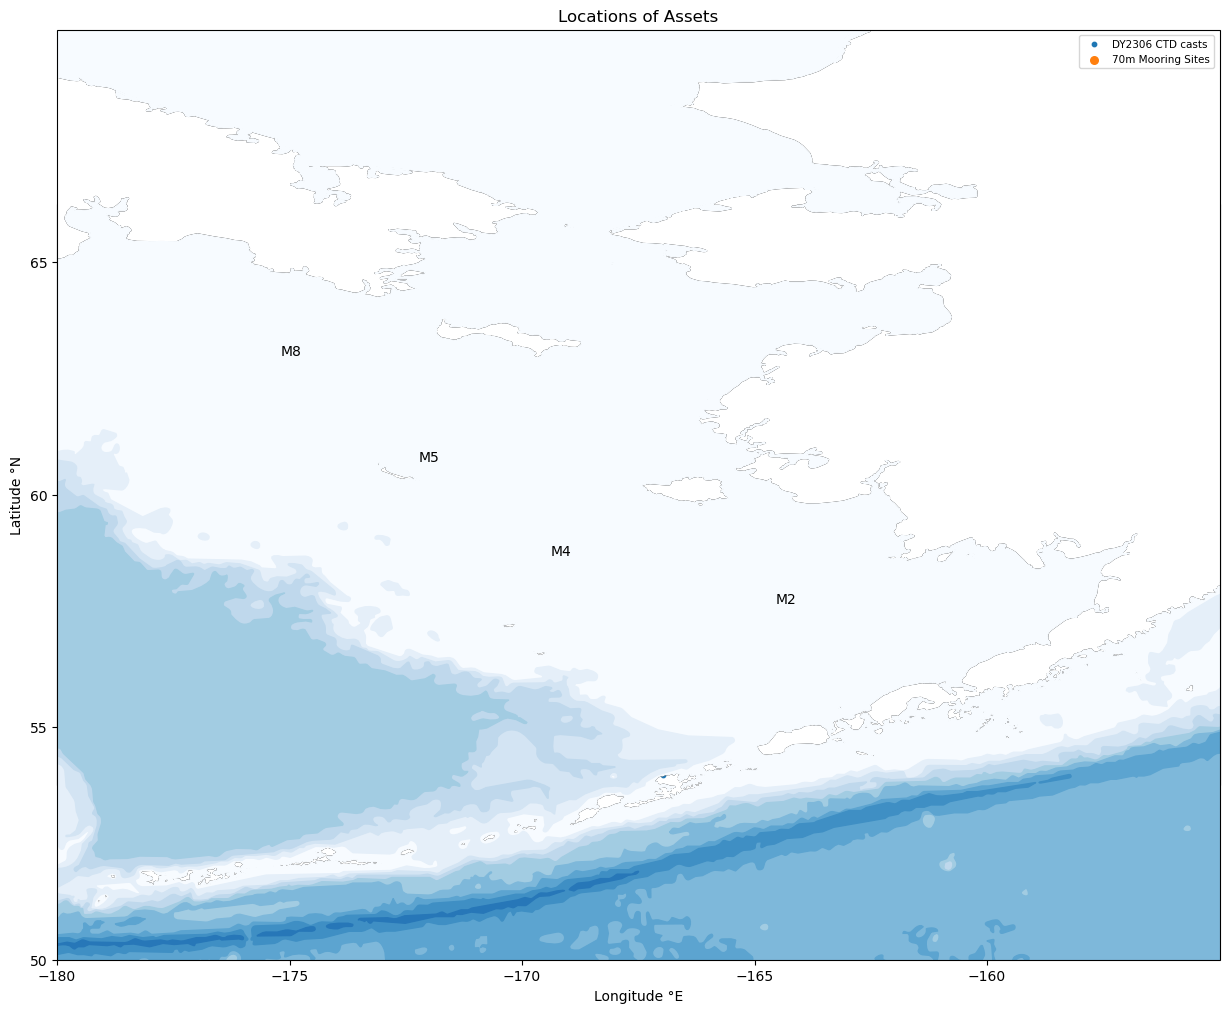

In [110]:
#create map 
fig, ax = plt.subplots(subplot_kw = {'projection': ccrs.PlateCarree()},figsize=(15,15) )
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(resolution='10m')
ax.set_extent([-180, -155, 50, 70], crs=ccrs.PlateCarree())

#bathymetry 
for i, depth_str in enumerate(depths_str):
    ax.add_geometries(shp_dict[depth_str].geometries(),
                      crs=ccrs.PlateCarree(),
                      color=colors_depths[i])
    
#import and plot DY2306CTD locations
dy2306_locs = pd.read_csv("/Users/anjalishah/Desktop/ECOFOCI2024/Data/CTDDY2306/EcoFOCI DY2306 CTD Locations.csv")
lat_dy2306 = dy2306_locs['Lat (N)']
lon_dy2306 = dy2306_locs['Lon (W)']

ax.scatter(lon_dy2306, lat_dy2306, s=10, transform=ccrs.PlateCarree())

#import and plot Mooring locations 
mooring_locs = pd.read_csv("/Users/anjalishah/Desktop/ECOFOCI2024/Data/Mooring_Sites/70m_Line_Mooring.csv")
names = mooring_locs['Name']
lat_moorings = mooring_locs['Latitude (N)']
lon_moorings = mooring_locs['Longitude (E)']

M2 = lon_moorings[0], lat_moorings[0]
M4 = lon_moorings[1], lat_moorings[1]
M5 = lon_moorings[2], lat_moorings[2]
M8 = lon_moorings[3], lat_moorings[3]

ax.scatter(lon_moorings, lat_moorings, s=30)
for i, label in enumerate(names):
    ax.annotate(label, (lon_moorings[i], lat_moorings[i]), xytext=(lon_moorings[i]-0.5, lat_moorings[i] + 0.8))

#import and plot glider locations 
glider_locs = pd.read_csv("/Users/anjalishah/Desktop/ECOFOCI2024/Data/OCULUS_Glider/OCULUS_glider_coordinates.csv")

#create plot labels and legend
ax.set_xticks(np.arange(-180, -155, 5), crs=ccrs.PlateCarree())
ax.set_xlabel('Longitude °E')
ax.set_ylabel('Latitude °N')
ax.set_yticks(np.arange(50, 70, 5), crs=ccrs.PlateCarree())
ax.legend(['DY2306 CTD casts', '70m Mooring Sites', 'OCULUS 05_23'], fontsize=7.5)
ax.set_title('Locations of Assets')
plt.show()



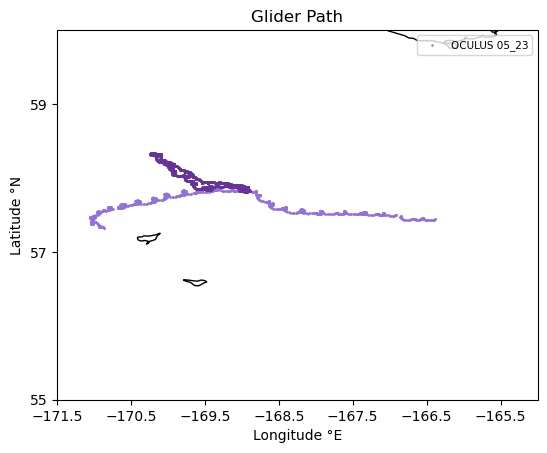

In [3]:
#plot ice proximate glider data 
#create map 
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.set_extent([-171.5, -165, 55, 60], crs=ccrs.PlateCarree())

#import and plot glider locations 
glider_locs = pd.read_csv("/Users/anjalishah/Desktop/ECOFOCI2024/Data/OCULUS_Glider/OCULUS_glider_coordinates.csv")
glider_ice_locs = glider_locs[(glider_locs['dive'] >= 673) & (glider_locs['dive'] <= 1812)]
lat_glider_ice = glider_ice_locs["avg_latitude"]
lon_glider_ice = glider_ice_locs["avg_longitude"]
lat_glider = glider_locs["avg_latitude"]
lon_glider = glider_locs["avg_longitude"]
ax.scatter(lon_glider, lat_glider, s=0.5, color='mediumpurple', transform=ccrs.PlateCarree())
ax.scatter(lon_glider_ice, lat_glider_ice, s=1, color='rebeccapurple', transform=ccrs.PlateCarree())

ax.scatter(lat_glider, lon_glider)

ax.set_xticks(np.arange(-171.5, -165, 1), crs=ccrs.PlateCarree())
ax.set_xlabel('Longitude °E')
ax.set_ylabel('Latitude °N')
ax.set_yticks(np.arange(55, 60, 2), crs=ccrs.PlateCarree())

ax.legend(['OCULUS 05_23'], fontsize=7.5)
ax.set_title('Glider Path')
plt.show()

In [4]:
#import netCDF files into new data frame 

filenames = '/Users/anjalishah/Desktop/EcoFOCI2024/Data/OCULUS_Glider/netcdf_withpar/p402*.nc'

# pull out only science variables
names = [
    'ctd_depth',
    'ctd_time',
    'salinity',
    'temperature',
    'wlbb2fl_sig695nm_adjusted',
    'wlbb2fl_sig700nm_adjusted',
    'aanderaa4330_dissolved_oxygen',
    'aa4330_airsat',
    'satPAR_PARuV', 
    'satPAR_time'
]

ds_dict = gt.load.seaglider_basestation_netCDFs(
    filenames, names,
    return_merged=False,
    keep_global_attrs=False,
)

print(ds_dict)



DIMENSION: ctd_data_point
{temperature, ctd_depth, longitude, ctd_time, latitude, salinity}


100%|██████████| 2583/2583 [00:13<00:00, 190.64it/s]


/Users/anjalishah/Desktop/EcoFOCI2024/Data/OCULUS_Glider/netcdf_withpar/p4020001.nc was skipped
/Users/anjalishah/Desktop/EcoFOCI2024/Data/OCULUS_Glider/netcdf_withpar/p4020002.nc was skipped
/Users/anjalishah/Desktop/EcoFOCI2024/Data/OCULUS_Glider/netcdf_withpar/p4020003.nc was skipped
/Users/anjalishah/Desktop/EcoFOCI2024/Data/OCULUS_Glider/netcdf_withpar/p4020004.nc was skipped
/Users/anjalishah/Desktop/EcoFOCI2024/Data/OCULUS_Glider/netcdf_withpar/p4020005.nc was skipped
/Users/anjalishah/Desktop/EcoFOCI2024/Data/OCULUS_Glider/netcdf_withpar/p4020006.nc was skipped
/Users/anjalishah/Desktop/EcoFOCI2024/Data/OCULUS_Glider/netcdf_withpar/p4020007.nc was skipped
/Users/anjalishah/Desktop/EcoFOCI2024/Data/OCULUS_Glider/netcdf_withpar/p4020008.nc was skipped
/Users/anjalishah/Desktop/EcoFOCI2024/Data/OCULUS_Glider/netcdf_withpar/p4020009.nc was skipped
/Users/anjalishah/Desktop/EcoFOCI2024/Data/OCULUS_Glider/netcdf_withpar/p4020010.nc was skipped
/Users/anjalishah/Desktop/EcoFOCI2024/Da

100%|██████████| 2583/2583 [00:11<00:00, 231.76it/s]


/Users/anjalishah/Desktop/EcoFOCI2024/Data/OCULUS_Glider/netcdf_withpar/p4020001.nc was skipped
/Users/anjalishah/Desktop/EcoFOCI2024/Data/OCULUS_Glider/netcdf_withpar/p4020002.nc was skipped
/Users/anjalishah/Desktop/EcoFOCI2024/Data/OCULUS_Glider/netcdf_withpar/p4020003.nc was skipped
/Users/anjalishah/Desktop/EcoFOCI2024/Data/OCULUS_Glider/netcdf_withpar/p4020004.nc was skipped
/Users/anjalishah/Desktop/EcoFOCI2024/Data/OCULUS_Glider/netcdf_withpar/p4020005.nc was skipped
/Users/anjalishah/Desktop/EcoFOCI2024/Data/OCULUS_Glider/netcdf_withpar/p4020006.nc was skipped
/Users/anjalishah/Desktop/EcoFOCI2024/Data/OCULUS_Glider/netcdf_withpar/p4020007.nc was skipped
/Users/anjalishah/Desktop/EcoFOCI2024/Data/OCULUS_Glider/netcdf_withpar/p4020008.nc was skipped
/Users/anjalishah/Desktop/EcoFOCI2024/Data/OCULUS_Glider/netcdf_withpar/p4020009.nc was skipped
/Users/anjalishah/Desktop/EcoFOCI2024/Data/OCULUS_Glider/netcdf_withpar/p4020010.nc was skipped
/Users/anjalishah/Desktop/EcoFOCI2024/Da

100%|██████████| 2583/2583 [00:11<00:00, 224.88it/s]


/Users/anjalishah/Desktop/EcoFOCI2024/Data/OCULUS_Glider/netcdf_withpar/p4020001.nc was skipped
/Users/anjalishah/Desktop/EcoFOCI2024/Data/OCULUS_Glider/netcdf_withpar/p4020002.nc was skipped
/Users/anjalishah/Desktop/EcoFOCI2024/Data/OCULUS_Glider/netcdf_withpar/p4020003.nc was skipped
/Users/anjalishah/Desktop/EcoFOCI2024/Data/OCULUS_Glider/netcdf_withpar/p4020004.nc was skipped
/Users/anjalishah/Desktop/EcoFOCI2024/Data/OCULUS_Glider/netcdf_withpar/p4020005.nc was skipped
/Users/anjalishah/Desktop/EcoFOCI2024/Data/OCULUS_Glider/netcdf_withpar/p4020006.nc was skipped
/Users/anjalishah/Desktop/EcoFOCI2024/Data/OCULUS_Glider/netcdf_withpar/p4020007.nc was skipped
/Users/anjalishah/Desktop/EcoFOCI2024/Data/OCULUS_Glider/netcdf_withpar/p4020008.nc was skipped
/Users/anjalishah/Desktop/EcoFOCI2024/Data/OCULUS_Glider/netcdf_withpar/p4020009.nc was skipped
/Users/anjalishah/Desktop/EcoFOCI2024/Data/OCULUS_Glider/netcdf_withpar/p4020010.nc was skipped
/Users/anjalishah/Desktop/EcoFOCI2024/Da

100%|██████████| 2583/2583 [00:10<00:00, 237.70it/s]


/Users/anjalishah/Desktop/EcoFOCI2024/Data/OCULUS_Glider/netcdf_withpar/p4020001.nc was skipped
/Users/anjalishah/Desktop/EcoFOCI2024/Data/OCULUS_Glider/netcdf_withpar/p4020002.nc was skipped
/Users/anjalishah/Desktop/EcoFOCI2024/Data/OCULUS_Glider/netcdf_withpar/p4020003.nc was skipped
/Users/anjalishah/Desktop/EcoFOCI2024/Data/OCULUS_Glider/netcdf_withpar/p4020004.nc was skipped
/Users/anjalishah/Desktop/EcoFOCI2024/Data/OCULUS_Glider/netcdf_withpar/p4020005.nc was skipped
/Users/anjalishah/Desktop/EcoFOCI2024/Data/OCULUS_Glider/netcdf_withpar/p4020006.nc was skipped
/Users/anjalishah/Desktop/EcoFOCI2024/Data/OCULUS_Glider/netcdf_withpar/p4020007.nc was skipped
/Users/anjalishah/Desktop/EcoFOCI2024/Data/OCULUS_Glider/netcdf_withpar/p4020008.nc was skipped
/Users/anjalishah/Desktop/EcoFOCI2024/Data/OCULUS_Glider/netcdf_withpar/p4020009.nc was skipped
/Users/anjalishah/Desktop/EcoFOCI2024/Data/OCULUS_Glider/netcdf_withpar/p4020010.nc was skipped
/Users/anjalishah/Desktop/EcoFOCI2024/Da

In [5]:
#cannot merge on software due to interpolation issue - try on own - has to do with not dropping the datetime column
#make datetime column index value!

#ctd data
df1=ds_dict['ctd_data_point'].to_dataframe()
df1.set_index(df1['ctd_time_dt64'],inplace=True)
df1.drop(labels='ctd_time_dt64',axis=1,inplace=True)
df1

# fluorometer data
df2=ds_dict['wlbb2fl_data_point'].to_dataframe()
df2.set_index(df2['wlbb2fl_results_time_dt64'],inplace=True)
df2.drop(labels='wlbb2fl_results_time_dt64',axis=1,inplace=True)

merged = df1.join(df2, sort=True, how="outer", rsuffix="_drop")

# oxygen data
df1=merged
df3=ds_dict['aa4330_data_point'].to_dataframe()
df3.set_index(df3['aa4330_time_dt64'],inplace=True)
df3.drop(labels='aa4330_time_dt64',axis=1,inplace=True)

merged = df1.join(df3, sort=True, how="outer", rsuffix="_drop")

#par data 
df1=merged
df4=ds_dict['scicon_satpar_satPAR_data_point'].to_dataframe()
df4.set_index(df4['satPAR_time_dt64'],inplace=True)
df4.drop(labels='satPAR_time_dt64',axis=1,inplace=True)

df = df1.join(df4, sort=True, how="outer", rsuffix="_drop")

print(df)

                     temperature  ctd_depth   longitude      ctd_time  \
2023-05-05 17:47:30     1.493907   1.486224 -166.914063  1.683309e+09   
2023-05-05 17:47:31     1.493739   1.486224 -166.914064  1.683309e+09   
2023-05-05 17:47:32     1.493722   1.486224 -166.914064  1.683309e+09   
2023-05-05 17:47:32     1.493623   1.486224 -166.914065  1.683309e+09   
2023-05-05 17:47:33     1.493482   1.486224 -166.914066  1.683309e+09   
...                          ...        ...         ...           ...   
2023-06-14 16:57:53     5.660396   1.098286 -170.867365  1.686762e+09   
2023-06-14 16:57:54     5.660169   0.939166 -170.867365  1.686762e+09   
2023-06-14 16:57:55     5.660011   0.780363 -170.867364  1.686762e+09   
2023-06-14 16:57:56     5.660377   0.690798 -170.867363  1.686762e+09   
2023-06-14 16:57:57     5.659495   0.690798 -170.867363  1.686762e+09   

                      latitude   salinity   dives  wlbb2fl_sig695nm_adjusted  \
2023-05-05 17:47:30  57.496223        NaN  

In [6]:
down = df[df.dives - (df.dives // 1) == 0]
up = df[df.dives - (df.dives // 1) != 0]

In [7]:

def glider_spatial_with_params(subgridded_data, title_temp, title_chlor, title_sal, title_oxy): 
    #create plot labels and legend
    fig, ax = plt.subplots(2,2,subplot_kw = {'projection': ccrs.PlateCarree()},figsize=(20, 20) )
    fig.tight_layout(pad=3)
    ax[1,1].coastlines()
    #create map 
    for i,j in np.array([[0, 0], [0, 1], [1, 0], [1, 1]]): 
        ax[i,j].coastlines()  
        ax[i,j].set_extent([-171.5, -168, 57, 59], crs=ccrs.PlateCarree())  #
        ax[i,j].set_xticks(np.arange(-171.5, -168, 0.5), crs=ccrs.PlateCarree())#
        ax[i,j].set_xlabel('Longitude °E',fontsize=15)
        #ax[i,j].set_xticklabels(labels=np.arange(-171.5, -166, 2), fontsize=15, transform=ccrs.PlateCarree())
        ax[i,j].set_ylabel('Latitude °N', fontsize=15)
        #ax[i,j].set_yticklabels(labels=np.arange(55, 60, 1), fontsize=15, transform=ccrs.PlateCarree())
        ax[i,j].set_yticks(np.arange(57, 59, 0.5), crs=ccrs.PlateCarree()) #
        
    
    
    #plot temperature  
    lat_glider = subgridded_data["latitude"]
    lon_glider = subgridded_data["longitude"]
    temperature = subgridded_data["temperature"]
    temp_plot = ax[0,0].scatter(lon_glider, lat_glider, s=3, c=temperature, cmap = cmocean.cm.thermal, transform=ccrs.PlateCarree())
    temp_cbar = plt.colorbar(temp_plot, ax=ax[0,0], shrink=0.5)
    temp_cbar.set_label('Temperature °C')
    ax[0,0].set_title(title_temp, fontsize=18)
    
    #plot chlorophyll 
    chlorophyll = subgridded_data["wlbb2fl_sig695nm_adjusted"]
    chlor_plot = ax[0,1].scatter(lon_glider, lat_glider, s=3, c=chlorophyll, cmap = cmocean.cm.algae, transform=ccrs.PlateCarree())
    temp_cbar = plt.colorbar(chlor_plot, ax=ax[0,1], shrink=0.5)
    temp_cbar.set_label('Chlorophyll (${\mu}$grams/liter)')
    ax[0,1].set_title(title_chlor, fontsize=18)
    
    
    #plot salinity 
    salinity = subgridded_data["salinity"]
    sal_plot = ax[1,0].scatter(lon_glider, lat_glider, s=3, c=salinity, cmap = cmocean.cm.haline, transform=ccrs.PlateCarree())
    sal_cbar = plt.colorbar(sal_plot, ax=ax[1,0], shrink=0.5)
    sal_cbar.set_label('Salinity (PSU)')
    ax[1,0].set_title(title_sal, fontsize=18)
    
    #plot oxygen
    oxygen = subgridded_data["aa4330_airsat"]
    oxy_plot = ax[1,1].scatter(lon_glider, lat_glider, s=3, c=oxygen, cmap = cmocean.cm.diff_r, transform=ccrs.PlateCarree())
    oxy_cbar = plt.colorbar(oxy_plot, ax=ax[1,1], shrink=0.5)
    oxy_cbar.set_label('Oxygen (% saturation)')
    ax[1,1].set_title(title_oxy, fontsize=18)

In [9]:
#plot surface
subgridded_surface = down[down['ctd_depth']<3].groupby('dives').mean() #take values at surface (top 3m) wihin the same dive, and average them
#glider_spatial_with_params(subgridded_surface, 'Surface Temperature', 'Surface Chl-a', 'Surface Salinity', 'Surface Oxygen')

#calculate difference in temp/salinity/oxygen (bottom and surface) --> plot delta
subgridded_bottom = down[down['ctd_depth']>60].groupby('dives').mean()
subgridded_max = down.groupby('dives').max()

In [9]:
#co-locate stratified area w/algae + phytoplankton bloom
delta_subgridded['ctd_time'] = delta_subgridded['ctd_time'].apply(lambda time: datetime.datetime.fromtimestamp(time)) #convert the average timestamp for each dive (calculated with groupby.mean() above) to give datetimes
delta_subgridded = delta_subgridded.set_index([delta_subgridded['ctd_time']])
#plot co-located data
#plot entire timeseries as blank dots (no parameters)
fig, ax = plt.subplots(2,2,subplot_kw = {'projection': ccrs.PlateCarree()},figsize=(20, 20) )
fig.tight_layout(pad=3)
ax[1,1].coastlines()
#create map 
for i,j in np.array([[0, 0], [0, 1], [1, 0], [1, 1]]): 
    ax[i,j].coastlines()  
    ax[i,j].set_extent([-170.5, -169, 57.5, 58.5], crs=ccrs.PlateCarree())  #
    ax[i,j].set_xticks(np.arange(-170.5, -169, 0.5), crs=ccrs.PlateCarree())#
    ax[i,j].set_xlabel('Longitude °E',fontsize=15)
    #ax[i,j].set_xticklabels(labels=np.arange(-171.5, -166, 2), fontsize=15, transform=ccrs.PlateCarree())
    ax[i,j].set_ylabel('Latitude °N', fontsize=15)
    #ax[i,j].set_yticklabels(labels=np.arange(55, 60, 1), fontsize=15, transform=ccrs.PlateCarree())
    ax[i,j].set_yticks(np.arange(57.7, 58.5, 0.5), crs=ccrs.PlateCarree()) #
  
title_temp = r'$\Delta$Temperature (surface-bottom)'
title_chlor='Max chl-a'
title_sal = r'$\Delta$Salinity (surface-bottom)'
title_oxy = r'$\Delta$Oxygen (surface-bottom)'  

#plot temperature  
lat_glider = subgridded_surface["latitude"]
lon_glider = subgridded_surface["longitude"]
temperature = subgridded_surface["temperature"]
temp_plot = ax[0,0].scatter(lon_glider, lat_glider, s=0.5, c='white', edgecolors = 'black', transform=ccrs.PlateCarree())
ax[0,0].set_title(title_temp, fontsize=18)

#plot chlorophyll 
chlorophyll = subgridded_surface["wlbb2fl_sig695nm_adjusted"]
chlor_plot = ax[0,1].scatter(lon_glider, lat_glider, s=0.5, c='white', edgecolors = 'black', transform=ccrs.PlateCarree())
ax[0,1].set_title(title_chlor, fontsize=18)


#plot salinity 
salinity = subgridded_surface["salinity"]
sal_plot = ax[1,0].scatter(lon_glider, lat_glider, s=0.5, c='white', edgecolors = 'black', transform=ccrs.PlateCarree())
ax[1,0].set_title(title_sal, fontsize=18)

#plot oxygen
oxygen = subgridded_surface["aa4330_airsat"]
oxy_plot = ax[1,1].scatter(lon_glider, lat_glider, s=0.5, c='white', edgecolors = 'black', transform=ccrs.PlateCarree())
ax[1,1].set_title(title_oxy, fontsize=18)

#plot stratified area w/algae + phytoplankton bloom
start_chlor = '2023-05-22 00:00:00'
end_chlor = '2023-05-28 23:59:59'

ice_prox_subgridded = delta_subgridded [start_chlor:end_chlor]
#plot temperature  
lat_glider = ice_prox_subgridded["latitude"]
lon_glider = ice_prox_subgridded["longitude"]
temperature = ice_prox_subgridded["temperature"]
temp_plot = ax[0,0].scatter(lon_glider, lat_glider, s=20, c=temperature, cmap = cmocean.cm.thermal, transform=ccrs.PlateCarree())
temp_cbar = plt.colorbar(temp_plot, ax=ax[0,0], shrink=0.5)
temp_cbar.set_label('Temperature °C')
ax[0,0].set_title(title_temp, fontsize=18)

#plot chlorophyll 
chlorophyll = ice_prox_subgridded["wlbb2fl_sig695nm_adjusted"]
chlor_plot = ax[0,1].scatter(lon_glider, lat_glider, s=20, c=chlorophyll, cmap = cmocean.cm.algae, transform=ccrs.PlateCarree())
temp_cbar = plt.colorbar(chlor_plot, ax=ax[0,1], shrink=0.5)
temp_cbar.set_label('Chlorophyll (${\mu}$grams/liter)')
ax[0,1].set_title(title_chlor, fontsize=18)

#plot salinity 
salinity = ice_prox_subgridded["salinity"]
sal_plot = ax[1,0].scatter(lon_glider, lat_glider, s=20, c=salinity, cmap = cmocean.cm.haline, transform=ccrs.PlateCarree())
sal_cbar = plt.colorbar(sal_plot, ax=ax[1,0], shrink=0.5)
sal_cbar.set_label('Salinity (PSU)')
ax[1,0].set_title(title_sal, fontsize=18)

#plot oxygen
oxygen = ice_prox_subgridded["aa4330_airsat"]
oxy_plot = ax[1,1].scatter(lon_glider, lat_glider, s=20, c=oxygen, cmap = cmocean.cm.diff_r, transform=ccrs.PlateCarree())
oxy_cbar = plt.colorbar(oxy_plot, ax=ax[1,1], shrink=0.5)
oxy_cbar.set_label('Oxygen (% saturation)')
ax[1,1].set_title(title_oxy, fontsize=18)

NameError: name 'delta_subgridded' is not defined

In [15]:
subgridded_surface['ctd_time'] = subgridded_surface['ctd_time'].apply(lambda time: datetime.datetime.fromtimestamp(time)) #convert the average timestamp for each dive (calculated with groupby.mean() above) to give datetimes
subgridded_surface = subgridded_surface.set_index([subgridded_surface['ctd_time']])

,temperature,ctd_depth,longitude,latitude,ctd_time,salinity,wlbb2fl_results_time,wlbb2fl_sig700nm_adjusted,wlbb2fl_sig695nm_adjusted,dives_drop,aa4330_time,aanderaa4330_dissolved_oxygen,aa4330_airsat,dives_drop,satPAR_time,satPAR_PARuV,dives_drop
dives,,,,,,,,,,,,,,,,,
119.0,1.493979,1.887987,-166.914067,57.496224,1.683309e+09,32.133210,1.683309e+09,0.163350,1.975325,119.0,1.683309e+09,0.0,93.477333,119.0,1.683309e+09,58.570000,119.0
120.0,1.498032,1.121969,-166.916648,57.496345,1.683310e+09,32.132614,1.683310e+09,0.169400,1.853317,120.0,1.683310e+09,0.0,93.438400,120.0,1.683310e+09,84.338200,120.0
121.0,1.493425,1.812811,-166.919806,57.495089,1.683312e+09,32.135180,1.683312e+09,0.157300,1.866425,121.0,1.683312e+09,NaN,93.604667,121.0,1.683312e+09,86.826333,121.0
122.0,1.493194,1.703878,-166.924634,57.493882,1.683314e+09,32.133567,1.683314e+09,0.151250,1.560900,122.0,1.683314e+09,NaN,93.643667,122.0,1.683314e+09,113.575750,122.0
123.0,1.497669,1.649760,-166.930495,57.493149,1.683316e+09,32.132521,1.683316e+09,0.169400,1.294700,123.0,1.683316e+09,NaN,93.794000,123.0,1.683316e+09,131.912667,123.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2573.0,5.441749,0.462433,-170.906998,57.344181,1.686747e+09,32.223360,1.686747e+09,0.175208,2.602952,2573.0,1.686747e+09,0.0,106.737240,2573.0,1.686747e+09,-0.057520,2573.0
2574.0,5.397887,2.324894,-170.906998,57.344181,1.686748e+09,32.246264,1.686748e+09,0.177467,2.835433,2574.0,1.686748e+09,0.0,106.856250,2574.0,1.686748e+09,-0.055667,2574.0
2575.0,5.447935,1.796278,-170.889095,57.342691,1.686750e+09,32.226211,1.686750e+09,0.169400,3.424300,2575.0,1.686750e+09,NaN,107.447667,2575.0,1.686750e+09,-0.020333,2575.0


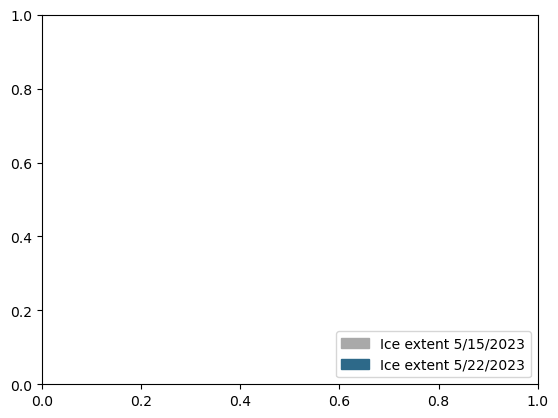

In [30]:
from matplotlib.patches import Patch

# Define the discrete colors and their labels
colors = ['#2d7c89','#2a186c','firebrick']
labels = ['Regime 1', 'Regime 2', 'Regime 3']

# Create the patches for each color
patches_1 = [Patch(color=color, label=label) for color, label in zip(colors, labels)]

# Create a figure and axis
fig, ax = plt.subplots()

# Add the legend to the plot
ax.legend(handles=patches_1, loc='upper right')

colors_2 = ['darkgrey', '#2d6989']
labels_2 = ['Ice extent 5/15/2023', 'Ice extent 5/22/2023']

patches_2 = [Patch(color=color, label=label) for color, label in zip(colors_2, labels_2)]
ax.legend(handles=patches_2, loc='lower right')

# Display the plot (the plot itself is empty, but it has the legend)
plt.show()

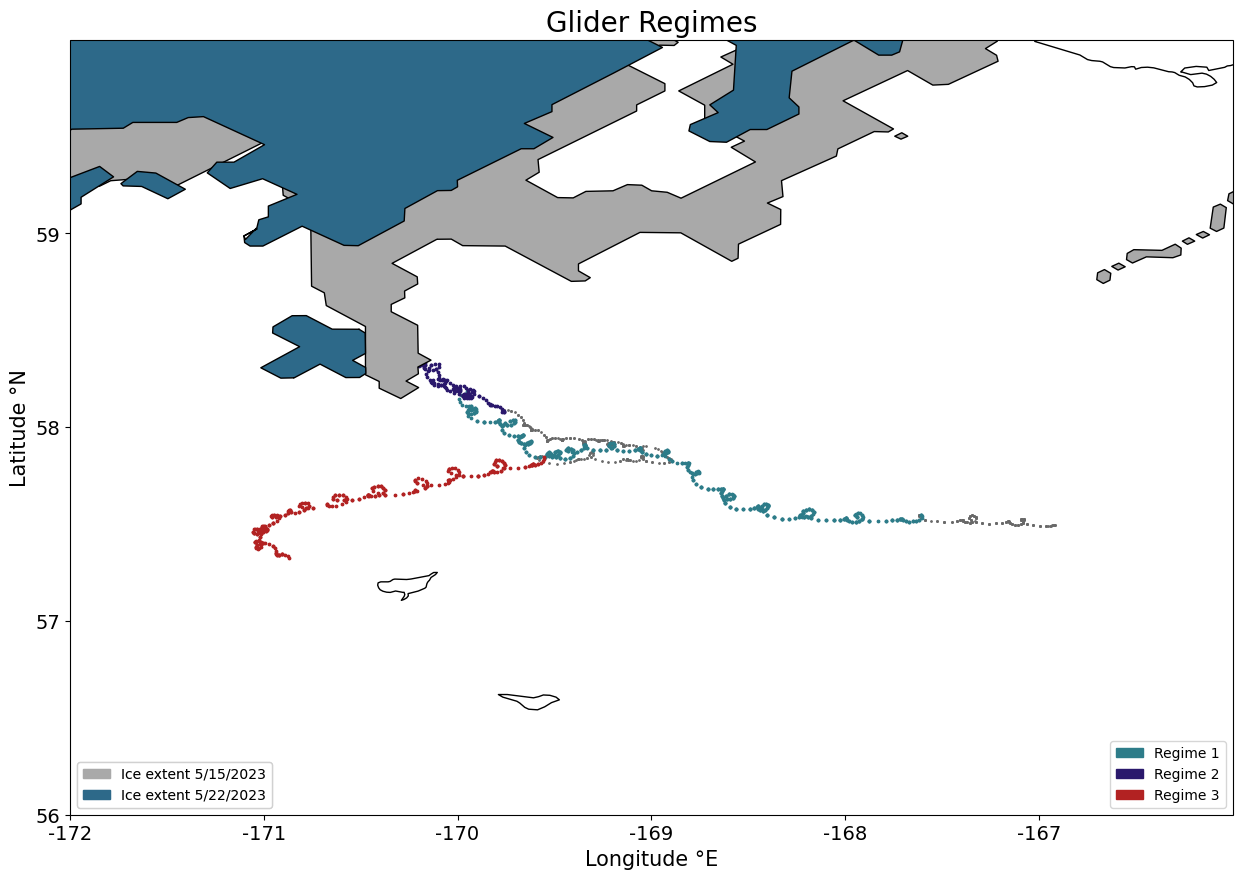

In [31]:


fig, ax = plt.subplots(subplot_kw = {'projection': ccrs.PlateCarree()},figsize=(15,15) )
ax.coastlines(lw=1, resolution='10m')
ax.set_extent([-172, -166, 56, 60], crs=ccrs.PlateCarree())
ax.set_xticks(np.arange(-172, -166, 1), crs=ccrs.PlateCarree())
ax.set_xlabel('Longitude °E', fontsize=15)
ax.set_ylabel('Latitude °N', fontsize=15)
ax.set_yticks(np.arange(56, 60, 1), crs=ccrs.PlateCarree())
ax.set_yticklabels(np.arange(56, 60, 1), fontsize=14)
ax.set_xticklabels(np.arange(-172, -166, 1), fontsize=14)

r1_start_date = '2023-05-08 00:46:08.262000'
r1_end_date = '2023-05-20 23:07:21.258429'

r2_start_date = '2023-05-21 00:14:14.258286'
r2_end_date = '2023-05-27 00:37:15.279875'

r3_start_date = '2023-06-04 00:12:10.704067'
r3_end_date = '2023-06-14 09:03:20.211313'

lat_glider = subgridded_surface["latitude"]
lon_glider = subgridded_surface["longitude"]

ice_5_14 = Reader('/Users/anjalishah/Desktop/EcoFOCI2024/ice_514_presentation.shp')
ice_5_22 = Reader('/Users/anjalishah/Desktop/EcoFOCI2024/ice_5_22_presentation.shp')

#bathymetry 
# for i, depth_str in enumerate(depths_str):
#     ax.add_geometries(shp_dict[depth_str].geometries(),
#                       crs=ccrs.PlateCarree(),
#                       color=colors_depths[i])
#ax.add_feature(cfeature.LAND, color='lightgray')

#ice 
shape_feature_14 = ShapelyFeature(ice_5_14.geometries(),
                               ccrs.PlateCarree())

shape_feature_22 = ShapelyFeature(ice_5_22.geometries(),
                               ccrs.PlateCarree())
ax.add_feature(shape_feature_14, edgecolor='black', facecolor = 'darkgrey') #eac16e
ax.add_feature(shape_feature_22, edgecolor='black', facecolor='#2d6989') #e6c5e1

#glider
ax.scatter(lon_glider, lat_glider, s=1, c='dimgray', transform=ccrs.PlateCarree())
ax.scatter(subgridded_surface[r1_start_date:r1_end_date]["longitude"], subgridded_surface[r1_start_date:r1_end_date]["latitude"], s=3, color='#2d7c89',transform=ccrs.PlateCarree())
ax.scatter(subgridded_surface[r2_start_date:r2_end_date]["longitude"], subgridded_surface[r2_start_date:r2_end_date]["latitude"], s=3, color='#2a186c',transform=ccrs.PlateCarree())
ax.scatter(subgridded_surface[r3_start_date:r3_end_date]["longitude"], subgridded_surface[r3_start_date:r3_end_date]["latitude"], s=3, color='firebrick',transform=ccrs.PlateCarree())


regime_legend = ax.legend(handles=patches_1, loc='lower right')
ice_legend = ax.legend(handles=patches_2, loc='lower left')
ax.add_artist(regime_legend)
ax.add_artist(ice_legend)
ax.set_title('Glider Regimes', fontsize=20)

#ax.gridlines(draw_labels=False)
#ax.set_position([0.03, 0.05, 0.8, 0.9])

# Add custom colorbar
#axi = fig.add_axes([0.85, 0.1, 0.025, 0.8])
#ax.add_feature(cfeature.BORDERS, linestyle=':')
#sm = plt.cm.ScalarMappable(cmap=blues_cm, norm=norm)
#fig.colorbar(mappable=sm,
             #cax=axi,
             #spacing='proportional',
             #extend='min',
             #ticks=depths,
             #label='Depth (m)')

# Convert vector bathymetries to raster (saves a lot of disk space)
# while leaving labels as vectors
ax.set_rasterized(True) 

plt.show()

In [21]:
subgridded_surface[r1_start_date:r1_end_date]["longitude"]

ctd_time
2023-05-08 00:46:08.262000   -167.605403
2023-05-08 01:05:09.225783   -167.605407
2023-05-08 01:22:11.752621   -167.605404
2023-05-08 01:51:33.774800   -167.601659
2023-05-08 02:57:12.278700   -167.604394
                                 ...    
2023-05-20 18:23:51.744334   -169.988899
2023-05-20 19:31:22.247286   -169.993650
2023-05-20 20:49:00.244562   -169.984275
2023-05-20 21:55:40.751000   -169.963116
2023-05-20 23:07:21.258429   -169.948729
Name: longitude, Length: 605, dtype: float64

In [38]:
# Defining the pb_opt calculations based on the given temperature criteria

# Behrenfeld & Falkowski NPP (VGPM model) 1998
# pb_opt is essentially a growth term (for the phyto community). in the VPGM this is modeled base don temperature (based on empircal data)
def calculate_global_pb_opt(temp):
    if pd.isna(temp):
        return np.nan
    elif temp < -10.0:
        return 0.00
    elif temp < -1.0:
        return 1.13
    elif temp > 28.5:
        return 4.00
    elif -1.0 <= temp <= 28.5:
        return (1.2956 + 0.2749*temp + 6.17e-2*temp**2 - 2.05e-2*temp**3 + 
                2.462e-3*temp**4 - 1.348e-4*temp**5 + 3.4132e-6*temp**6 - 
                3.27e-8*temp**7)
    else:
        return np.nan

# apply func to temp column
subgridded_surface['global_pb_opt'] = subgridded_surface['temperature'].apply(calculate_global_pb_opt)

# Kameda & Ishizaka 2005 - pb_opt calculation
### different pb opt (production to biomass) function - here includes total chla (simulating that large cells (with different growth) are dominant in high chla (~chla >2ug/l) areas )
subgridded_surface['pb_opt_kameda'] = ((0.071 * subgridded_surface['temperature'] - 3.2e-3 * subgridded_surface['temperature']**2 + 
                        3.0e-5 * subgridded_surface['temperature']**3) / subgridded_surface['wlbb2fl_sig695nm_adjusted'] + 
                       (1.0 + 0.17 * subgridded_surface['temperature'] - 2.5e-3 * subgridded_surface['temperature']**2 + 
                        8.0e-5 * subgridded_surface['temperature']**3))

# Convert chlorophyll in micrograms/L to milligrams/m^3
subgridded_surface['chl_a_milligrams'] = (.001/.001) * subgridded_surface['wlbb2fl_sig695nm_adjusted']

# Calculate NPP (Net Primary Production)
subgridded_surface['Npp_global'] = (subgridded_surface['chl_a_milligrams'] * subgridded_surface['global_pb_opt'] * 
                    (0.66125 * subgridded_surface['satPAR_PARuV'] / (subgridded_surface['satPAR_PARuV'] + 4.1)) * 15) 

subgridded_surface['Npp_kameda'] = (subgridded_surface['chl_a_milligrams'] * subgridded_surface['pb_opt_kameda'] * 
                    (0.66125 * subgridded_surface['satPAR_PARuV'] / (subgridded_surface['satPAR_PARuV'] + 4.1)) * 15)

In [22]:
subgridded_surface[r1_start_date:r1_end_date]

,longitude,salinity,temperature,ctd_depth,latitude,ctd_time,wlbb2fl_results_time,wlbb2fl_sig700nm_adjusted,wlbb2fl_sig695nm_adjusted,dives_drop,aanderaa4330_dissolved_oxygen,aanderaa4330_results_time,aa4330_airsat,dives_drop,satPAR_PARuV,satPAR_time,dives_drop
dives,,,,,,,,,,,,,,,,,


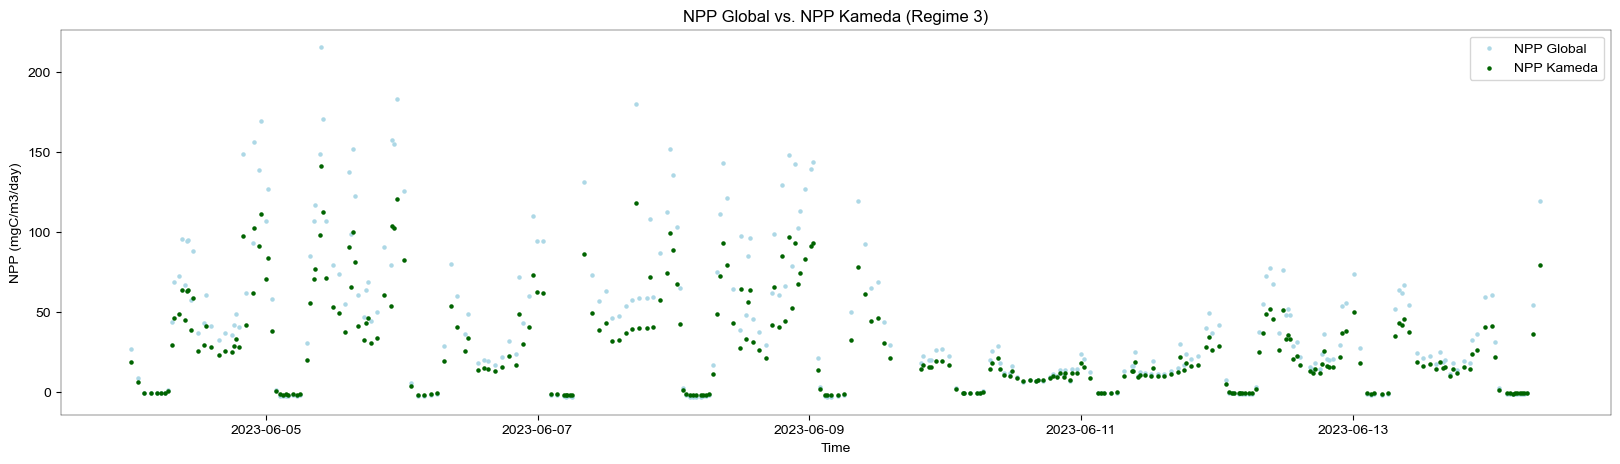

29.10223592062008

In [99]:
plt.figure(figsize=(20,5))
#plot regime 1: 
r1_start_date = '2023-05-08 00:46:08.262000'
r1_end_date = '2023-05-20 23:07:21.258429'

r2_start_date = '2023-05-21 00:14:14.258286'
r2_end_date = '2023-05-27 00:37:15.279875'

r3_start_date = '2023-06-04 00:12:10.704067'
r3_end_date = '2023-06-14 09:03:20.211313'

plt.scatter(subgridded_surface[r3_start_date:r3_end_date].index, subgridded_surface['Npp_global'][r3_start_date:r3_end_date], color='lightblue', s = 5)
plt.scatter(subgridded_surface[r3_start_date:r3_end_date].index, subgridded_surface['Npp_kameda'][r3_start_date:r3_end_date], color='darkgreen', s = 5)
plt.title('NPP Global vs. NPP Kameda (Regime 3)')
plt.xlabel('Time')
plt.ylabel('NPP (mgC/m3/day)')
plt.legend(['NPP Global', 'NPP Kameda'])
plt.show()

subgridded_surface['Npp_kameda'][r3_start_date:r3_end_date].mean()

In [49]:
subgridded_surface_daily = subgridded_surface.groupby(subgridded_surface.index.date).mean()

AttributeError: 'Index' object has no attribute 'date'

TypeError: '<' not supported between instances of 'datetime.date' and 'str'

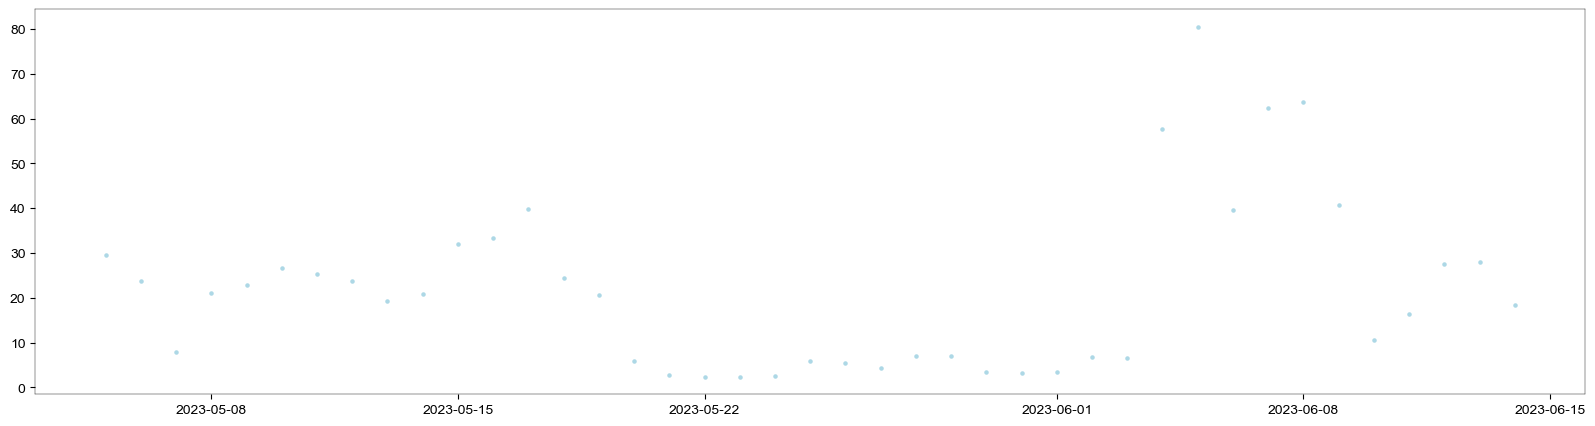

In [50]:
plt.figure(figsize=(20,5))
	
plt.scatter(subgridded_surface_daily.index, subgridded_surface_daily['Npp_global'], color='lightblue', s = 5)
plt.scatter(subgridded_surface_daily.index, subgridded_surface_daily['Npp_kameda']['2023-05-08 00:46:08.262000':'2023-05-20 23:07:21.258429'], color='darkgreen', s = 5)
plt.title('NPP Global vs. NPP Kameda')
plt.xlabel('Time')
plt.ylabel('NPP (mgC/m3/day)')
plt.legend(['NPP Global', 'NPP Kameda'])
#plt.errorbar(subgridded_surface_daily.index, subgridded_surface_daily['Npp_global'], yerr = statistics.stdev(subgridded_surface_daily['Npp_global']), fmt = 'o', color='lightblue')
#plt.errorbar(subgridded_surface_daily.index, subgridded_surface_daily['Npp_kameda'], yerr = statistics.stdev(subgridded_surface_daily['Npp_kameda']), fmt = 'o', color='darkgreen')
plt.show()

In [58]:
#create feature matrix for clusters: average temp, average salinity, average oxygen, average chlorophyll, delta_t, delta_s, delta_o, max_chlor, depth_max_chlor

#get average values 
subgridded_cluster_features = subgridded_avg.copy()

#get delta values 
subgridded_cluster_features['delta_temperature'] = subgridded_surface['temperature']-subgridded_bottom['temperature']
subgridded_cluster_features['delta_salinity'] = subgridded_surface['salinity']-subgridded_bottom['salinity']
subgridded_cluster_features['delta_oxy'] = subgridded_surface['aa4330_airsat']-subgridded_bottom['aa4330_airsat']
subgridded_cluster_features['max_chlor'] = subgridded_max['wlbb2fl_sig695nm_adjusted'] #input chlorophyll max parameter into delta matrix (instead of surf-bottom)
subgridded_cluster_features['avg_temperature'] = subgridded_avg['temperature']
subgridded_cluster_features['avg_sal'] = subgridded_avg['salinity']
subgridded_cluster_features['avg_oxy'] = subgridded_avg['aa4330_airsat']
subgridded_cluster_features['avg_chlor'] = subgridded_avg['wlbb2fl_sig695nm_adjusted']

In [38]:
idx = down.groupby('dives')['wlbb2fl_sig695nm_adjusted'].transform('max') == down['wlbb2fl_sig695nm_adjusted'] 
#gives the maximum chlor amount for each dive, assigns it to all of the timepoints associated with that dive
#set equal to down[chlor] to find the indices with the maximum value!!
subgridded_cluster_features['depth_max_chlor']= down[idx]['ctd_depth']

2023-05-05 17:48:53    15.098857
2023-05-05 18:12:54     2.550304
2023-05-05 18:43:58     8.796029
2023-05-05 19:14:16    12.456911
2023-05-05 19:39:28     3.527469
                         ...    
2023-06-14 14:52:12    21.697983
2023-06-14 15:11:20    18.865008
2023-06-14 15:31:15    21.536784
2023-06-14 16:05:11    21.471387
2023-06-14 16:43:38    23.296959
Name: ctd_depth, Length: 2494, dtype: float64

In [59]:
subgridded_cluster_features

,ctd_time,ctd_depth,latitude,temperature,salinity,longitude,wlbb2fl_time,wlbb2fl_sig695nm_adjusted,wlbb2fl_sig700nm_adjusted,dives_drop,...,satPAR_time,dives_drop,delta_temperature,delta_salinity,delta_oxy,max_chlor,avg_temperature,avg_sal,avg_oxy,avg_chlor
dives,,,,,,,,,,,,,,,,,,,,,
119.0,1.683309e+09,37.358107,57.496284,1.326203,32.130708,-166.914517,1.683309e+09,1.260504,0.160983,119.0,...,1.683309e+09,119.0,0.253564,0.005796,4.478521,2.7225,1.326203,32.130708,90.581380,1.260504
120.0,1.683311e+09,36.329586,57.496389,1.328437,32.130865,-166.917319,1.683311e+09,1.275213,0.165834,120.0,...,1.683311e+09,120.0,0.260586,0.005571,4.438462,2.2869,1.328437,32.130865,90.652789,1.275213
121.0,1.683312e+09,37.063944,57.495046,1.321718,32.130763,-166.920898,1.683312e+09,1.290334,0.163662,121.0,...,1.683312e+09,121.0,0.257207,0.008089,4.593400,2.4079,1.321718,32.130763,90.658750,1.290334
122.0,1.683314e+09,36.860651,57.493871,1.313437,32.130511,-166.925964,1.683314e+09,1.265737,0.161934,122.0,...,1.683314e+09,122.0,0.257575,0.006784,4.606738,2.4442,1.313437,32.130511,90.564602,1.265737
123.0,1.683316e+09,36.599696,57.493098,1.326914,32.130069,-166.931823,1.683316e+09,1.317453,0.164139,123.0,...,1.683316e+09,123.0,0.262340,0.005644,4.728857,2.2506,1.326914,32.130069,90.864500,1.317453
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2578.0,1.686754e+09,37.661680,57.336378,3.581780,32.246943,-170.874609,1.686754e+09,1.936139,0.177745,2578.0,...,1.686754e+09,2578.0,2.840597,-0.021930,20.882026,5.9048,3.581780,32.246943,94.792471,1.936139
2579.0,1.686756e+09,33.209262,57.336342,3.645575,32.246892,-170.874440,1.686756e+09,2.199113,0.179278,2579.0,...,1.686756e+09,2579.0,NaN,NaN,NaN,8.3853,3.645575,32.246892,95.296959,2.199113
2580.0,1.686757e+09,35.436458,57.336333,3.650642,32.243810,-170.874429,1.686757e+09,2.660254,0.183122,2580.0,...,1.686757e+09,2580.0,NaN,NaN,NaN,8.4216,3.650642,32.243810,95.662309,2.660254


dives
119.0     0.253564
120.0     0.260586
121.0     0.257207
122.0     0.257575
123.0     0.262340
            ...   
2578.0    2.840597
2579.0         NaN
2580.0         NaN
2581.0    2.912439
2583.0         NaN
Name: temperature, Length: 2410, dtype: float64